In [15]:
import numpy  as np
def sigma_od(t,gamma_oil):
    return (1.17013-1.694*10**(-3)*(1.8*t+32))*(38.085-0.259*(141.5/gamma_oil-131.5))


def relativesigma_go_od(rs):
    return (0.056379+0.94362*np.exp(-21.6128*10**(-3)*rs))

def sigma_og(t,gamma_oil,rs):
    return sigma_od(t,gamma_oil)*relativesigma_go_od(rs)

def sigma_og2(p_atm, t_c,gamma_o,wc_perc=0):
    #calculate surface tension according Baker Sverdloff correlation
    #расчет коэффициента поверхностного натяжения газ-нефть
    #st=serfase tension = поверхностное натяжение
    wc=wc_perc/100
    t_f=t_c*1.8+32
    p_psia=p_atm/0.068046
    p_mpa=p_atm/10
    oil_API=141.5/gamma_o-131.5 #???
    st68=39-0.2571*oil_API
    st100=37.5-0.2571*oil_API
    if t_f<68:
        sto=st68
    else:
        tst=t_f
        if t_f>100:
            tst=100
        sto=(68-(((tst-68)*(st68-st100))/32))*(1-(0.024*p_psia**(0.45)))
    #TOD stw, st calc_ST
    stw74=(75-(1.108*p_psia**(0.349)))
    stw280=(53-(0.1048*p_psia**(0.637)))
    if t_f<74:
        stw=stw74
    else:
        tstw=t_f
        if t_f>280:
            tstw=280
        stw=stw74-(((tstw-74)*(stw74-stw280))/206)
    stw=10**(-(1.19+0.01*p_mpa))*1000
    st=(stw*wc)+sto*(1-wc)
    
    return st
        
    
        
sigma=sigma_og(tintake_c,gammaoil,rp_m3m3)/1000
sigma2=sigma_og2(pintake_atm,tintake_c,gammaoil,wct_perc)/1000
sigma3=sigma_og2(pintake_atm,tintake_c,gammaoil,0)/1000
print(sigma)
print(sigma2)
print(sigma3)

0.004543513971282629
0.03370986366929509
0.028070723268140425


Проверка, пример использования функций сепарации, и сравнение с результатами UniflocVBA 7.4

При импорте модуля автоматический запускается тест на наличие ошибок

(В дальнейшей нужно осуществить переход на unittest)

In [3]:
import sys
sys.path.append('../')
import uPVT.PVT as PVT
import uPVT.PVT_correlations as PVTcorr
import math
import matplotlib.pyplot as plt
import pandas as pd
import uSep.separation as sp

Result of separation check:
qgas_scm3day -work right
qo_scm3day -work right
unf_calc_natural_separation -work right
unf_calc_total_separation -work right


Чтение данных, посчитанных с UniflocVBA 7.4

In [4]:
data = pd.read_excel('SepTestData.xlsx')

Исходные данные, одинаковы и для python, и для vba

In [5]:
pintake_atm=80
wct_perc=22
tintake_c=80
dintake_mm=100
dcasing_mm=125
gammagas=0.9
gammaoil=0.75
gammawater=1
rsb_m3m3=80
rp_m3m3=80
pb_atm=150
tres_c=120
bob_m3m3=1
sepgassep=0.50

Задание PVT свойств по Стендингу, необходимых для расчета

In [6]:
fluid=PVT.FluidStanding(gammaoil,gammagas,gammawater,rsb_m3m3)
fluid.calc(pintake_atm,tintake_c)

1

Вывод посчитанных значений PVT

In [7]:
def out(number,string):
    space=' - '
    print(str(number),space,string)
out(dintake_mm,'dintake_mm')
out(dcasing_mm,'dcasing_mm')
out(fluid.bo_m3m3,'bo_m3m3')
out(fluid.bg_m3m3,'bg_m3m3')
out(fluid.sigma_oil_Nm,'sigma_oil_Nm')
out(fluid.rho_oil_stkgm3,'rho_oil_stkgm3')
out(fluid.rho_gas_sckgm3,'rho_gas_sckgm3')
out(wct_perc,'wct_perc')

100  -  dintake_mm
125  -  dcasing_mm
1.9522964869459403  -  bo_m3m3
0.012673883940723262  -  bg_m3m3
0.0  -  sigma_oil_Nm
750.0  -  rho_oil_stkgm3
1.1025  -  rho_gas_sckgm3
22  -  wct_perc


Генерация зависимостей коэффицента общей и естесственной сепарации от дебита, посчитанных через UniflocVBA и UniflocPy

simgma_o = поверхностное натяжение = 200/100 - задается вручную

In [17]:
def getvalues(start=1,stop=300,step=10):
    q=[]
    sep=[]
    totalsep=[]
    for i in range(start,stop,step):
        q.append(i)
        #sigma_og=200/1000 При поверхностном натяжении 200 дин/см происходит совпадение графиков
        sigma=sigma_og(tintake_c,gammaoil,rp_m3m3)/1000
        #sigma=sigma_og2(pintake_atm,tintake_c,gammaoil,wct_perc)/1000
        natsep=sp.unf_calc_natural_separation(dintake_mm/1000,dcasing_mm/1000,
                                       i,
                                       sp.qgas_scm3day(sp.qo_scm3day(i,wct_perc),rp_m3m3),fluid.bo_m3m3,
                                       fluid.bg_m3m3,
                                       sigma,fluid.rho_oil_stkgm3,
                                       fluid.rho_gas_sckgm3,wct_perc)
        sep.append(natsep)
        totalsep.append(sp.unf_calc_total_separation(natsep,sepgassep))
      
              
    return [q,sep,totalsep]

result=getvalues()

Построение графиков

***Существует явное несовпадение графиков, а также неопределенность в определении поверхностного натяжения  - sigma_o***

необходима доработка

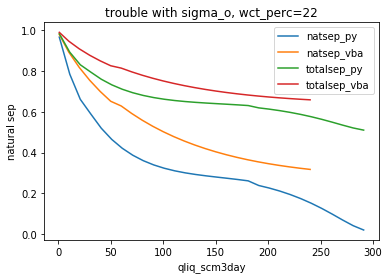

In [18]:
plt.plot(result[0],result[1],label='natsep_py')
plt.plot(data['Q'],data['Естественная сепарация 100 мм'],label='natsep_vba')
plt.plot(result[0],result[2],label='totalsep_py')
plt.plot(data['Q'],data['Общая сепарация'],label='totalsep_vba')
plt.ylabel('natural sep')
plt.xlabel('qliq_scm3day')
plt.title('trouble with sigma_o, wct_perc=22')
plt.legend()
plt.show()

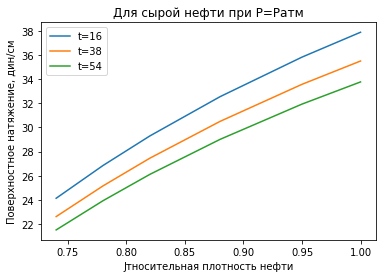

In [10]:
gamma_oil=np.asarray([1, 0.95, 0.88,0.82, 0.78, 0.74])
plt.plot(gamma_oil,sigma_od(16,gamma_oil),label='t=16')
plt.plot(gamma_oil,sigma_od(38,gamma_oil),label='t=38')
plt.plot(gamma_oil,sigma_od(54,gamma_oil),label='t=54')
#plt.plot(data['Q'],data['Общая сепарация'],label='totalsep_vba')
plt.ylabel('Поверхностное натяжение, дин/см')
plt.xlabel('Jтносительная плотность нефти')
plt.title('Для сырой нефти при Р=Ратм')
plt.legend()
plt.show()

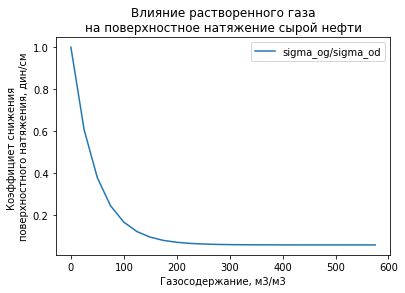

In [11]:
rs=(range(0,600,25))

result_relative_sigma=[]
for i in rs:
    relative_sigma=relativesigma_go_od(i)
    result_relative_sigma.append(relative_sigma)

plt.plot(rs,result_relative_sigma,label='sigma_og/sigma_od')
plt.ylabel('Коэффициет снижения '+'\n'+'поверхностного натяжения, дин/см')
plt.xlabel('Газосодержание, м3/м3')
plt.title('Влияние растворенного газа' +'\n'+ 'на поверхностное натяжение сырой нефти')
plt.legend()
plt.show()

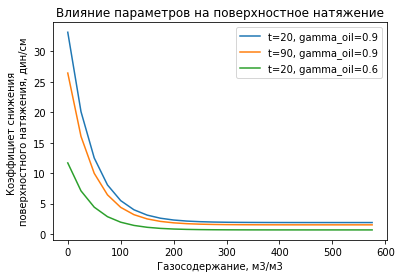

In [13]:
rs=(range(0,600,25))

one_result_sigma_og=[]
two_result_sigma_og=[]
three_result_sigma_og=[]
for i in rs:
    one_result_sigma_og.append(sigma_og(20,0.9,i))
    two_result_sigma_og.append(sigma_og(90,0.9,i))
    three_result_sigma_og.append(sigma_og(20,0.6,i))

plt.plot(rs,one_result_sigma_og,label='t=20, gamma_oil=0.9')
plt.plot(rs,two_result_sigma_og,label='t=90, gamma_oil=0.9')
plt.plot(rs,three_result_sigma_og,label='t=20, gamma_oil=0.6')
plt.ylabel('Коэффициет снижения '+'\n'+'поверхностного натяжения, дин/см')
plt.xlabel('Газосодержание, м3/м3')
plt.title('Влияние параметров на поверхностное натяжение')
plt.legend()
plt.show()

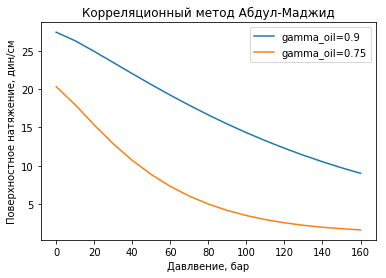

In [14]:

p=(range(0,170,10))
one_result_sigma_og=[]
two_result_sigma_og=[]
gamma_oil_1=0.9
gamma_oil_2=0.75
pb_MPaa=0
rsb_m3m3=0
gamma_gas=0.6
t_c=80
t_K=273+t_c
for i in p:
    rs1=PVTcorr.unf_rs_Standing_m3m3(i/10, pb_MPaa, rsb_m3m3, gamma_oil_1, gamma_gas, t_K)
    rs2=PVTcorr.unf_rs_Standing_m3m3(i/10, pb_MPaa, rsb_m3m3, gamma_oil_2, gamma_gas, t_K)
    one_result_sigma_og.append(sigma_og(t_c,gamma_oil_1,rs1))
    two_result_sigma_og.append(sigma_og(t_c,gamma_oil_2,rs2))


plt.plot(p,one_result_sigma_og,label='gamma_oil=0.9')
plt.plot(p,two_result_sigma_og,label='gamma_oil=0.75')

plt.ylabel('Поверхностное натяжение, дин/см')
plt.xlabel('Давлвение, бар')
plt.title('Корреляционный метод Абдул-Маджид')
plt.legend()
plt.show()